Task 5 - Step 1

     Year  Temperature change
0    1880               -0.40
1    1881               -0.37
2    1882               -0.43
3    1883               -0.47
4    1884               -0.72
..    ...                 ...
101  1981                0.42
102  1982                0.02
103  1983                0.30
104  1984                0.09
105  1985                0.05

[106 rows x 2 columns]


<Figure size 640x480 with 0 Axes>

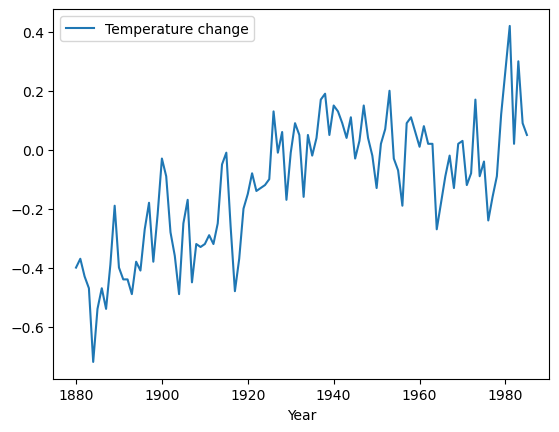

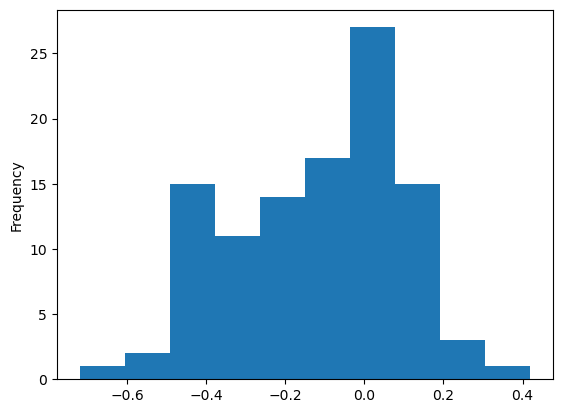

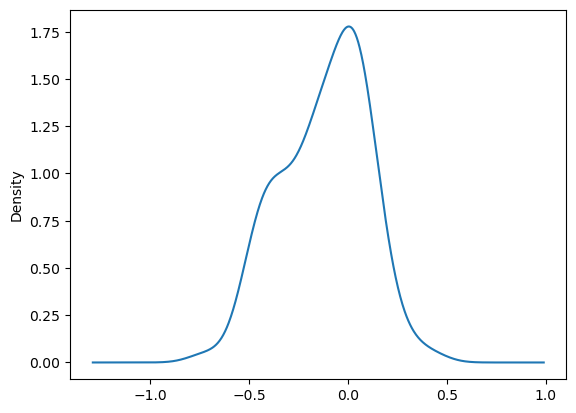

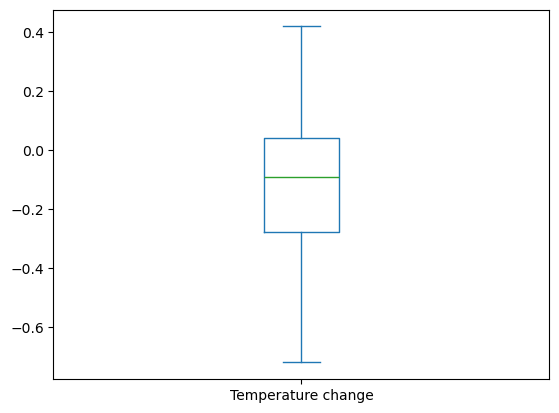

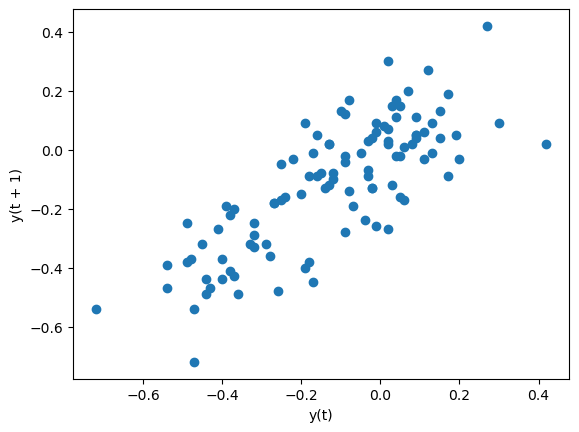

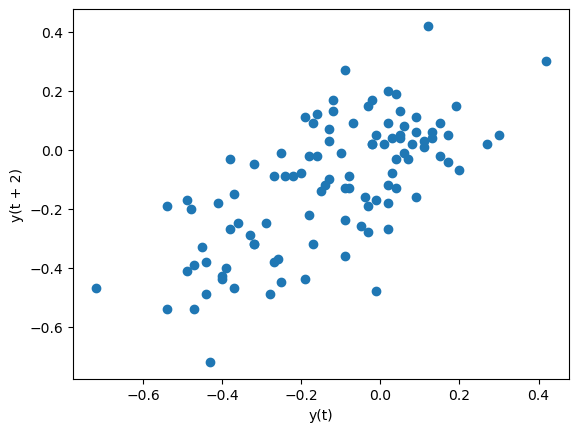

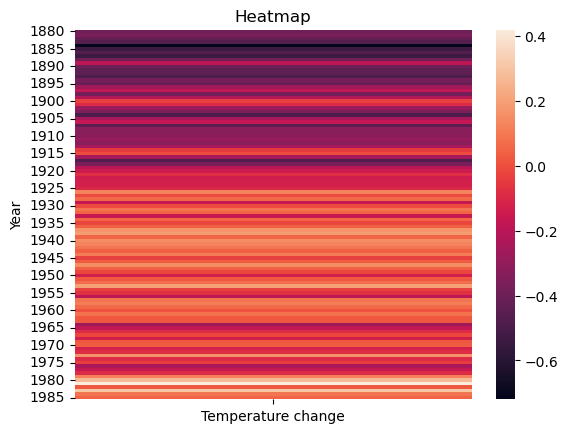

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
df = pd.read_csv("temp.csv")

series = df[["Year", "Temperature change"]]
plot_filename_base = "5"

# Convert the data to a Pandas Series
temp_series = pd.Series(series["Temperature change"])
print(series)

# Step 1: Randomness test
# Line plot
plt.figure()
series.plot.line(x = "Year")
plt.savefig(f'plots/{plot_filename_base}_line.png')
 
# Histogram
plt.figure()
temp_series.plot.hist()
plt.savefig(f'plots/{plot_filename_base}_hist.png')

# Density plot
plt.figure()
temp_series.plot.density()
plt.savefig(f'plots/{plot_filename_base}_density.png')

# Box plot
plt.figure()
temp_series.plot.box()
plt.savefig(f'plots/{plot_filename_base}_box.png')

# Lag-1 plot
plt.figure()
pd.plotting.lag_plot(temp_series, lag=1)
plt.savefig(f'plots/{plot_filename_base}_lag1.png')

# Lag-2 plot
plt.figure()
pd.plotting.lag_plot(temp_series, lag=2)
plt.savefig(f'plots/{plot_filename_base}_lag2.png')

# Heat
plt.figure() 
series.set_index("Year", inplace=True)
sns.heatmap(series)
plt.title('Heatmap')
plt.savefig(f'plots/{plot_filename_base}_heat.png')
plt.show()


In [214]:
import statsmodels.api as sm

#perform Ljung-Box test on residuals with lag=5
print(sm.stats.acorr_ljungbox(series["Temperature change"], lags=[1], return_df=True))

print("p value < 0.05. Thus we reject the null-value hypthesis. There is significant correlation")

     lb_stat     lb_pvalue
1  65.914271  4.709690e-16
p value < 0.05. Thus we reject the null-value hypthesis. There is significant auto-correlation


Step 2

From the above plots, it is clear the above data is not stationary. To confirm, we use ADF. 

In [215]:
from statsmodels.tsa.stattools import adfuller

result_1 = adfuller(series["Temperature change"], autolag='AIC')
print('ADF Statistic: %f' % result_1[0])
print('p-value: %f' % result_1[1])

print("Since the p-value is > 0.05, data is not stationary.")

ADF Statistic: -1.909132
p-value: 0.327778
Since the p-value is > 0.05, data is not stationary.


We employ differencing to remove trend

ADF Statistic: -6.387904
p-value: 0.000000


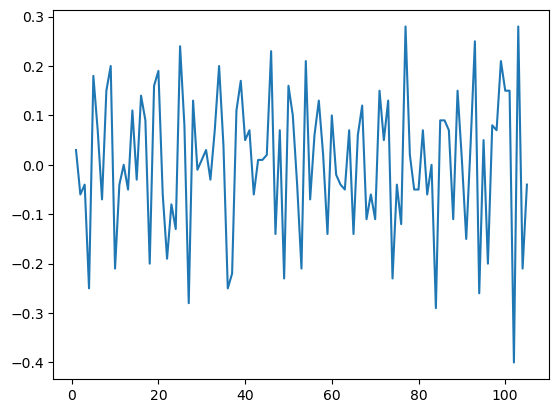

In [216]:
import pandas as pd

# Perform differencing
lag = 1
differenced_series = temp_series.diff(periods=lag)

# Line plot
plt.figure()
differenced_series.plot.line()
plt.savefig(f'plots/{plot_filename_base}_differenced_line.png')

# Check stationarity of differenced data
differenced_series[:lag] = 1
result_1 = adfuller(differenced_series, autolag='AIC')
print('ADF Statistic: %f' % result_1[0])
print('p-value: %f' % result_1[1])

Lag-1 differencing removed the trend. We move to Step 3

Step 3

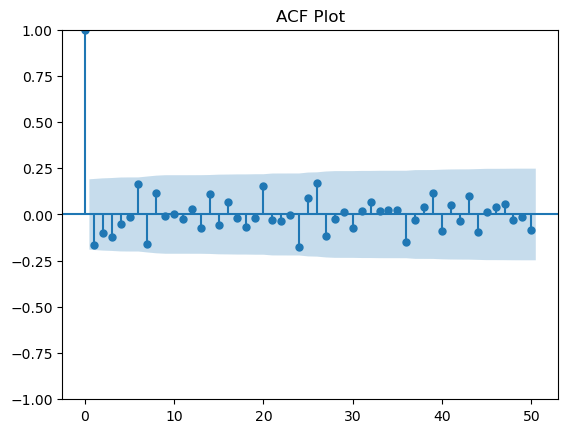

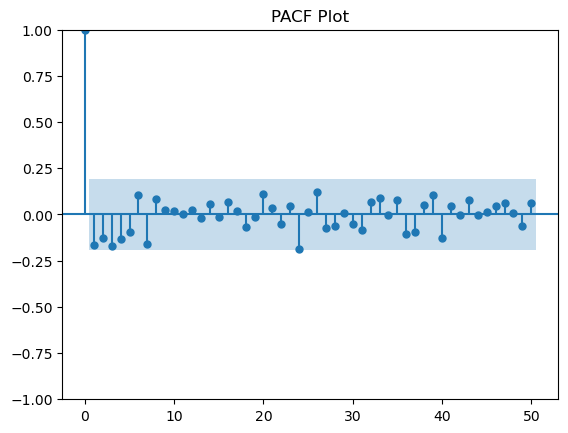

In [217]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(differenced_series, title='ACF Plot', lags=50)
plt.savefig(f'plots/{plot_filename_base}_ACF.png')

plot_pacf(differenced_series, title='PACF Plot', lags=50)
plt.savefig(f'plots/{plot_filename_base}_PACF.png')

To get p from PACF, we see where the upper confidence level is crossed for the first time
To get q from ACF,  we see where the upper confidence level is crossed for the first time

Thus, d = 1, p = 1, q = 1

Step 4

In [218]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

d = 1
p = 1
q = 1

# Fit auto ARIMA model
model = auto_arima(temp_series, d=d)
#model1=ARIMA(temp_series, order=(1,1,1))
#model1 = model1.fit()


# Print the summary of the best model
print(model.summary())
#print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  69.356
Date:                Thu, 02 May 2024   AIC                           -130.713
Time:                        22:18:38   BIC                           -120.097
Sample:                             0   HQIC                          -126.411
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0032      0.002      1.825      0.068      -0.000       0.007
ar.L1          0.3927      0.107      3.685      0.000       0.184       0.602
ma.L1         -0.8876      0.061    -14.517      0.0

Auto-Arima function returns an optimal (p,d,q) = (1,1,1). This is in line with our selection.

Step 5

0     -0.405325
1      0.024675
2     -0.058031
3     -0.063437
4     -0.287870
         ...   
101    0.277635
102   -0.215704
103    0.242392
104   -0.108042
105   -0.056663
Length: 106, dtype: float64
    lb_stat  lb_pvalue
1  0.020651   0.885733
p value is greater than 0.05. Thus the data is random
Mean:  -0.004789460357358056
Variance:  0.017129691001543105
Standard deviation:  0.13088044545134733
MSE:  0.01699102907355269


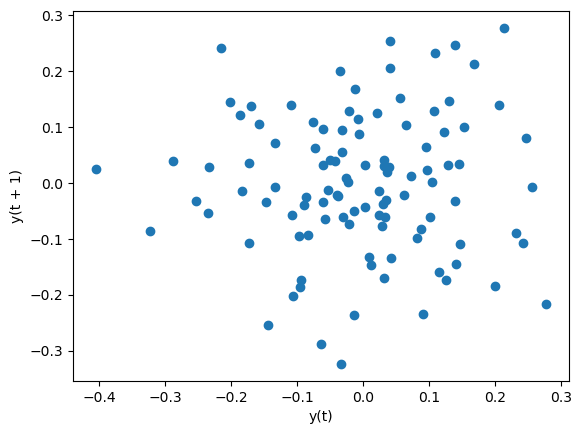

In [219]:
from sklearn.metrics import mean_squared_error

predictions = model.predict_in_sample()

# Get difference of predicted vs actual data
residual_series = model.resid()
print(residual_series)

#perform Ljung-Box test on residuals with lag=1
print(sm.stats.acorr_ljungbox(residual_series, lags=[1], return_df=True))

print("p value is greater than 0.05. Thus the data is random")

# Lag-1 plot
plt.figure()
pd.plotting.lag_plot(residual_series, lag=1)
plt.savefig(f'plots/{plot_filename_base}_residual_lag1.png')

# Show data characteristics
print('Mean: ', residual_series.mean())
print('Variance: ', residual_series.var())
print('Standard deviation: ', residual_series.std())

# MSE of model vs actual temp data
mse = mean_squared_error(temp_series, predictions)

print("MSE: ", mse)



Data is random. p_value > 0.05. This is also confirmed by the lag-1 plot.

Step 6

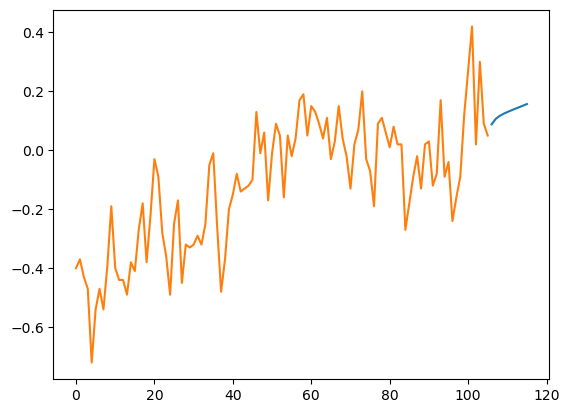

In [220]:
forecast = model.predict(n_periods=10)

# Line plot comparison of given data and predicted values
plt.figure()
forecast.plot.line()
temp_series.plot.line()

plt.savefig(f'plots/{plot_filename_base}_prediction_line.png')


Questions:
• Draw a line plot for the time series data. Do you observe any trend, season in the data?

Line plot indicates that there is an upward trend. Data is not stationary.

• Draw histogram, density plot, heat map, and box plot for the time series data. Are
there any outliers? Why?

No Outliers

• Draw lag-1 and lag-2 plots for the time series data. Do you observe any auto-correlation
from the lag plots?

Yes but it is not significant. 

• Is the series random? How do you check it? Do the three methods (line plot, lag-1
plot, and Ljung-Box test) give the same results?

The series is not random. There is clearly a trend in the line plot. The lag plots indicate an auto-correlation though it is not very significant in the lag plot. The Ljung-Box test returns a p-value < 0.05. Thus, we can reject the null-point hypthesis and confirm there is autocorrelation 

• Is the series stationary? Try with visual inspection and ADF test. Do they give the
same results?

The series is not stationary. The ADF test returns a p value > 0.05. Visual inspection clearly shows an upward trend.

• If the series is not stationary, how do you make it stationary? If you use the differencing operation, how do you decide a proper order of differencing without underdifferencing/over-differencing?

We use differencing to make the series stationary. We employed different d values and used visual inspection of plots to determine if the data is stationary. Our selection was confirmed through mean, median and mean-sequared error statistics.

• What (p, d, q) values do you use? How do you determine them?

we chose p,d,q values of 1,1,1. d was chosen based on visual insection of plots. p was chosen based on visual inspection of ACF plots and q was chosen based on visual inspection of PACF plots. The selection was confirmed by the auto_arima function which chose similar values.

• After model fitting, is the reminder series (in-sample prediction) considered to be white
noise?

Yes. The remainder series is random. This was confirmed  Ljung-Box test gave a p value of greater than 0.05 indicating independent data points. Visual inspection of the lag-1 plot also confirmed the same.

• What is the MSE of the fitted model for the data?

MSE of the fitted model: 0.01699102907355269

• For out-of-sample prediction, do the predicted values (10 steps) reflect the trend and
fluctuation of the series?

Predicts the trend without the fluctuations